In [2]:
import sys
import re
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import pandas.testing as pdt
import warnings
import logging

try:
    from pandas.core.common import SettingWithCopyWarning
except:
    from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", message=".*Parameter.*")

In [3]:
store = pd.HDFStore('data/optparam.h5')
opt = store['opt']
store.close()

In [4]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

In [5]:
import concurrent

In [6]:
from ciceroscm.parallel._configdistro import _ConfigDistro
from ciceroscm.parallel.calibrator import Calibrator
from ciceroscm.parallel.distributionrun import DistributionRun


/uio/kant/div-cicero-u1/bensan/ciceroscm-1/venv/lib/python3.8/site-packages/scmdata/database/_database.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman
/uio/kant/div-cicero-u1/bensan/ciceroscm-1/venv/lib/python3.8/site-packages/setuptools_scm/_integration/setuptools.py:31: RuntimeWarning: 
ERROR: setuptools==47.1.0 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(


<IPython.core.display.Javascript object>

Import the model

In [7]:
sys.path.insert(0,os.path.join(os.getcwd(), '../', 'src'))
from ciceroscm import CICEROSCM

Define some input handling functions to give us example inputs

In [8]:
from ciceroscm.input_handler import read_inputfile,read_components,read_natural_emissions

Define a function to convert model output to a dataframe

set up input directories

In [9]:
test_data_dir = os.path.join(os.getcwd(), '../../', 'tests', 'test-data')

# Read in datafiles into dataframes

In [10]:
# NBVAL_IGNORE_OUTPUT
#Read gas parameters
gaspam =read_components(test_data_dir + '/gases_v1RCMIP.txt')
gaspam.head()

,EM_UNIT,CONC_UNIT,BETA,ALPHA,TAU1,TAU2,TAU3,NAT_EM,SARF_TO_ERF
GAS,,,,,,,,,
CO2,Pg_C,ppm,2.123,0.00000,150.00,0,0,0.0,1.000000
CH4,Tg,ppb,2.780,0.00000,9.60,120,160,275.0,0.877193
N2O,Tg_N,ppb,4.810,0.00000,121.00,0,0,9.5,1.000000
SO2,Tg_S,-,11.000,0.00000,0.02,0,0,0.0,1.000000
CFC-11,Gg,ppt,22.600,0.00026,45.00,0,0,0.0,1.000000


Read natural emissions

In [136]:
# NBVAL_IGNORE_OUTPUT
df_nat_ch4 =read_natural_emissions(test_data_dir + '/natemis_ch4.txt','CH4')
df_nat_n2o =read_natural_emissions(test_data_dir + '/natemis_n2o.txt','N2O')
df_nat_ch4[:]=df_nat_ch4.iloc[0]
df_nat_n2o[:]=df_nat_n2o.iloc[0]

df_nat_ch4.head()


,CH4
year,
1750,269.4273
1751,269.4273
1752,269.4273
1753,269.4273
1754,269.4273


Read forcing

In [137]:
df_flat_conc =read_inputfile(test_data_dir + '/ssp245_conc_RCMIP.txt')
df_flat_conc =read_inputfile(test_data_dir + '/ssp245_conc_RCMIP.txt')
df_flat_conc[:]=df_flat_conc.iloc[0]

df_flat_conc.head()

,CO2,CH4,N2O,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,CH3Br,CCl4,...,HFC143a,HFC227ea,HFC23,HFC245fa,HFC32,HFC4310mee,C2F6,C6F14,CF4,SF6
Component,,,,,,,,,,,,,,,,,,,,,
1700,276.746,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1701,276.746,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1702,276.746,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1703,276.746,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1704,276.746,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0


In [138]:
emi_input =read_inputfile(test_data_dir + '/ssp245_em_RCMIP.txt')
emi_input.rename(columns={"CO2": "CO2_FF", "CO2.1": "CO2_AFOLU"}, inplace=True)
emi_input[:]=emi_input.iloc[0]*0

emi_input.head()

,CO2_FF,CO2_AFOLU,CH4,N2O,SO2,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,...,CF4,SF6,NOx,CO,NMVOC,NH3,BMB_AEROS_BC,BMB_AEROS_OC,BC,OC
Component,,,,,,,,,,,,,,,,,,,,,
1750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Set up model run with defined input variables

In [139]:
scendata={
            "gaspam_data": gaspam,
            "emstart": 1750,  
            "conc_run":False,
            "nystart": 1750,
            "nyend": 2100,
            "concentrations_data": df_flat_conc,
            "emissions_data": emi_input,
            "nat_ch4_data": df_nat_ch4,
            "nat_n2o_data": df_nat_n2o,
            "idtm":24,
            "udir": test_data_dir,
            "scenname": "ssp245",
        }

In [140]:
    calibdata = pd.DataFrame(
        data={
            "Variable Name": [
                "Heat Content|Ocean",
                "Surface Air Ocean Blended Temperature Change",
            ],
            "Yearstart_norm": [1971, 1961],
            "Yearend_norm": [1971, 1990],
            "Yearstart_change": [2018, 2000],
            "Yearend_change": [2018, 2019],
            "Central Value": [320.69251537323, 0.5372],
            "sigma": [17.020342912051203, 0.039028311931729676],
        })

In [141]:
    testconfig = _ConfigDistro(
        distro_array=np.array([        [5, 25],
        [0.04, 1],
        [0.161, 0.569],
        [0.55, 2.55],
        [0, 7],
        [2 / 3.71, 8 / 3.71]]),
        setvalues={
            "qbmb": 0,
            "qo3": 0.5,
            "threstemp": 7.0,
            "lm": 40,
            "ldtime": 12,
        },
    )

In [142]:
testconfig.ordering

['rlamdo',
 'akapa',
 'cpi',
 'W',
 'beto',
 'lambda',
 'mixed',
 'qdirso2',
 'qindso2',
 'qbc',
 'qoc',
 'beta_f',
 'mixed_carbon',
 'qh2o_ch4']

In [143]:
# NBVAL_IGNORE_OUTPUT
scen = 'test'
cscm_dir=CICEROSCM({
            "gaspam_data": gaspam,
            "emstart": 1750,  
            "conc_run":False,
            "nystart": 1750,
            "nyend": 2100,
            "concentrations_data": df_flat_conc,
            "emissions_data": emi_input,
            "nat_ch4_data": df_nat_ch4,
            "nat_n2o_data": df_nat_n2o,
            "idtm":24,
        })

In [144]:
len(opt)

1000

In [145]:
distrorun1 = DistributionRun(testconfig, numvalues=len(opt))
output_vars = ["Heat Uptake", "Surface Air Temperature Change"]


[ 5.          0.04        0.161       0.55        0.          0.53908356
 25.         -0.55       -1.5         0.1        -0.1         0.11
 25.          0.08      ]
[ 2.50000000e+01  1.00000000e+00  5.69000000e-01  2.55000000e+00
  7.00000000e+00  2.15633423e+00  1.25000000e+02 -2.00000000e-01
 -5.00000000e-01  2.00000000e-01 -6.00000000e-02  4.65000000e-01
  1.25000000e+02  1.00000000e-01]


In [146]:
def get_results(cfg):
    try:
        cscm_dir._run({"results_as_dict": True},pamset_udm=cfg['pamset_udm'],pamset_emiconc=cfg['pamset_emiconc'])
        res=cscm_dir.results

    except:
        res=None
    return [cfg,res]

In [147]:
def run_parallel(cfgs,nworkers=4):
    results=len(cfgs)*[None]
    with ProcessPoolExecutor(nworkers) as exe:
            # execute tasks concurrently and process results in order
            pres=list(tqdm(exe.map(get_results, cfgs)))
            for result in pres:
                # get the corresponding index of the config
                ind=int(result[0]['Index'])
                # put it in the right element of the results vector
                results[ind]=result[1]
    return results

In [148]:
distrorun1.cfgs[0].keys()

dict_keys(['pamset_udm', 'pamset_emiconc', 'Index'])

In [149]:
for j,c in enumerate(distrorun1.cfgs):
    for typ in ['pamset_udm','pamset_emiconc']:
        pkys=list(c[typ].keys())
        ins=list(set(opt.iloc[j].keys()).intersection(pkys))
        for i in ins:   
            c[typ][i]=opt.iloc[j][i]


In [150]:
cscm_dir._run({"results_as_dict": True},pamset_udm=distrorun1.cfgs[0]['pamset_udm'],pamset_emiconc=distrorun1.cfgs[0]['pamset_emiconc'])

In [151]:
results=run_parallel(distrorun1.cfgs,nworkers=100)

1000it [00:24, 40.58it/s]


<Axes: >

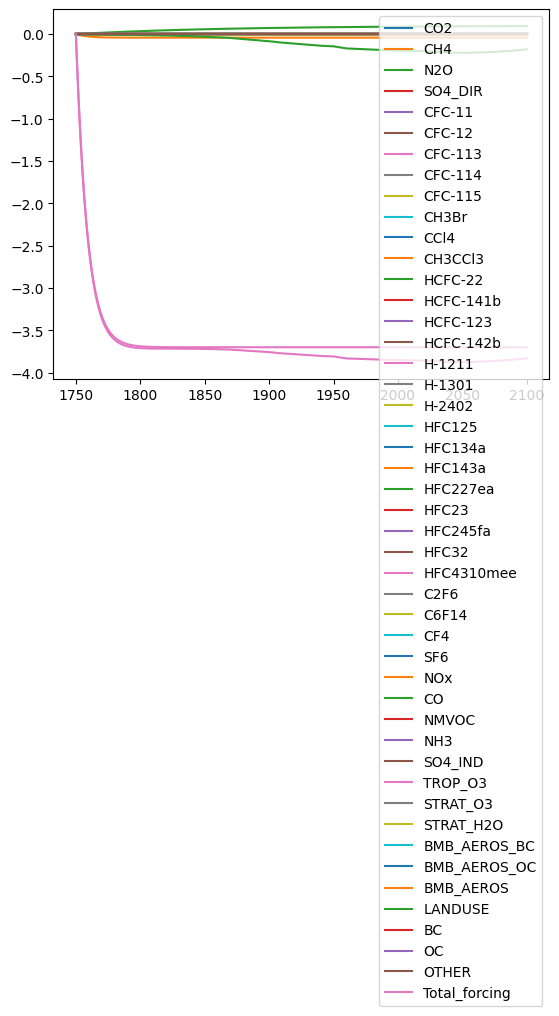

In [183]:
results[0]['forcing'].iloc[:,1:].plot()

<Axes: >

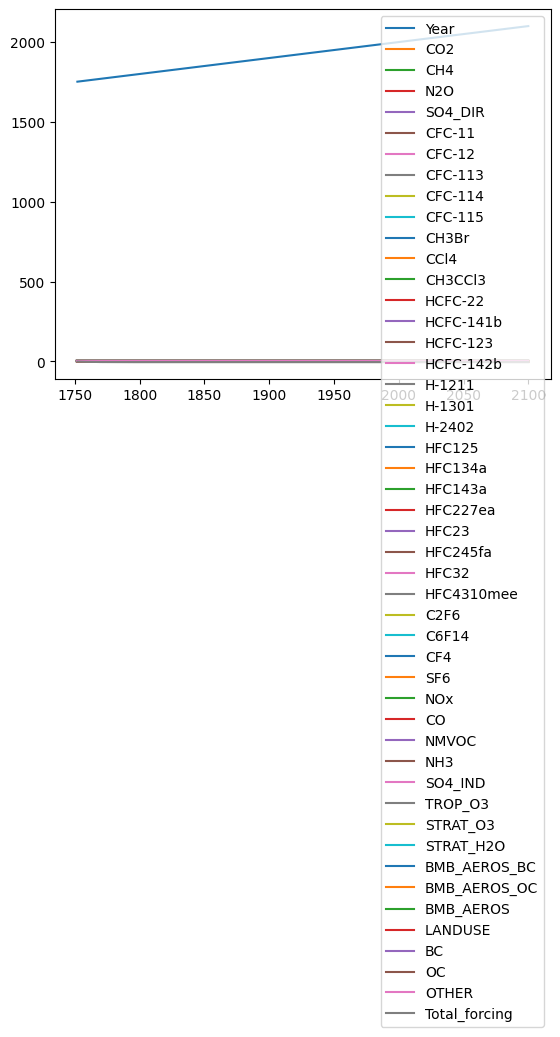

In [179]:
results[0]['forcing'].iloc[2:,:].plot()

In [167]:
flds=['dT_glob','OHC700','concentrations-CO2','RIB_glob']

In [168]:
isgd=np.where([r!=None for r in results])[0].astype(int)

In [169]:
fresults = [results[i] for i in isgd]
fcfgs=[distrorun1.cfgs[i] for i in isgd]

In [170]:
def to_df(rs):

    out=pd.concat([pd.DataFrame(v).reset_index(drop=True) for k, v in rs.items()], keys = rs.keys(),axis=1) 
    out.index=rs['forcing'].index
    return out

In [171]:
def make_ensdf(results,flds):
    resdf=[]
    for i,res in enumerate(results):
        df=to_df(res)
        test_list=df.columns.map('{0[0]}-{0[1]}'.format).tolist()
        df.columns=[sub.replace('-0', '') for sub in test_list]
        resdf.append(df[flds].unstack())
    ensdf=pd.concat(resdf,axis=1)
    return ensdf

In [172]:
df=make_ensdf(fresults,flds)

KeyError: "['Forcing'] not in index"

In [158]:
issane=np.where(df.max()<1e8)[0]

In [159]:
df1 = df.iloc[:,issane]
fcfgs1=[fcfgs[i] for i in issane]

In [160]:
df1.index.names = ['variable', 'year']
df1.columns.names=['run_id']

In [161]:
def plot_range(df, var, ax,col='k'):
    Tdf=df.xs(var).T
    lower = Tdf.quantile(0.10)
    upper = Tdf.quantile(0.90)
    ax.fill_between(Tdf.columns, lower, upper, color=col, alpha=0.2,edgecolor=None)
    ax.plot(Tdf.columns, Tdf.mean(), color=col)



(-1.0, 5.0)

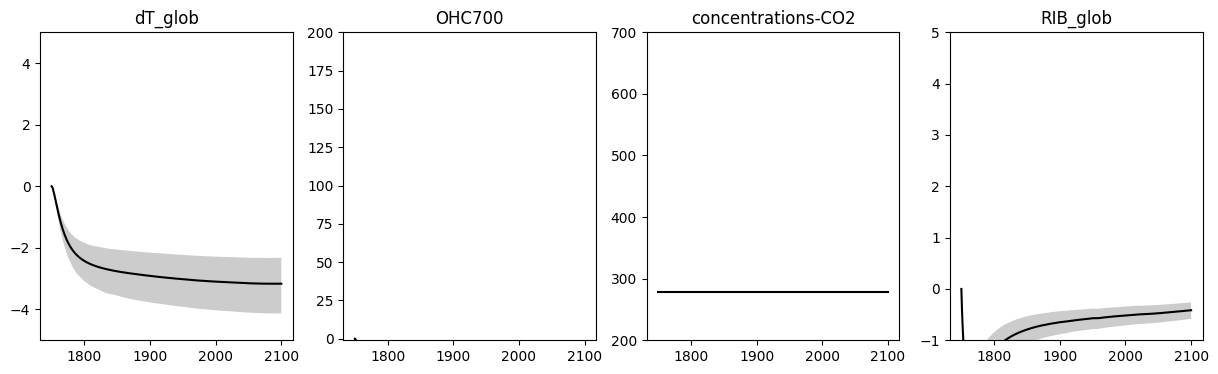

In [162]:
fig, ax = plt.subplots( 1,len(flds) ,figsize=(15, 4))

ax=ax.flatten()
for i,f in enumerate(flds):
    plot_range(df1, f, ax[i])
    ax[i].set_title(f)
ax[0].set_ylim([-5,5])
ax[1].set_ylim([-1,200])
ax[2].set_ylim([200,700])
ax[3].set_ylim([-1,5])

